# Lab 2

In [96]:
import utils as ut
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import pandas as pd
from importlib import reload

reload(ut)


<module 'utils' from '/Users/parkergeorge/UCSD/ASTR150/ASTRO150/utils.py'>

## Read in Data

In [53]:
files = glob.glob('Lab2_data/*.csv')
# Swap Hydrogen to the front and Lamp to the back
files[0], files[5] = files[5], files[0]
files[2], files[5] = files[5], files[2]
print(files)

['Lab2_data/Hydrogen.csv', 'Lab2_data/Helium.csv', 'Lab2_data/Mercury.csv', 'Lab2_data/Neon.csv', 'Lab2_data/fluorescent.csv', 'Lab2_data/lamp.csv']


In [105]:
all_data = ut.zeros(len(files))

for i, file in enumerate(files):
    # Read in csv file and skip the first 54 rows and the last line [End Of File]
    raw_data = pd.read_csv(file, engine='python',usecols=[0,1], skiprows=53, skipfooter=1)
    # Set the two columns of data to data type float
    raw_data['Pixel Number'] = raw_data['Pixel Number'].astype(float)
    raw_data['Measured Signal'] = raw_data['Measured Signal'].astype(float)

    all_data[i] = raw_data


all_data = np.array(all_data, dtype=np.float32)
all_data.shape

(6, 3648, 2)

## Plot all Data Files

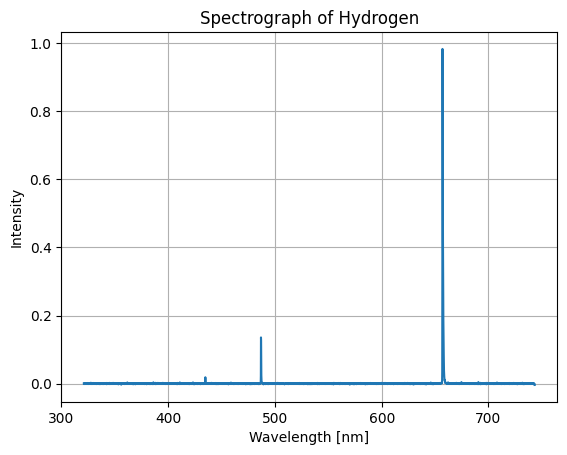

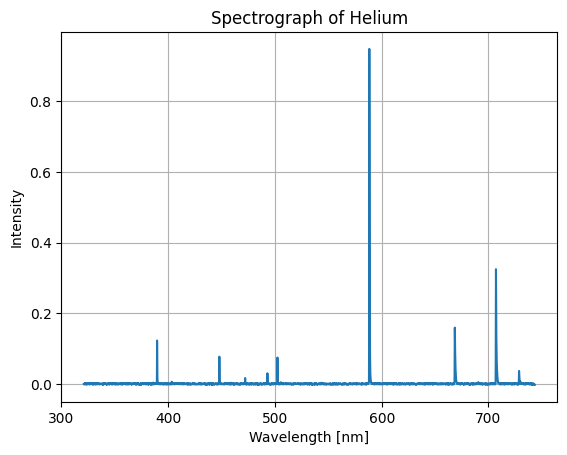

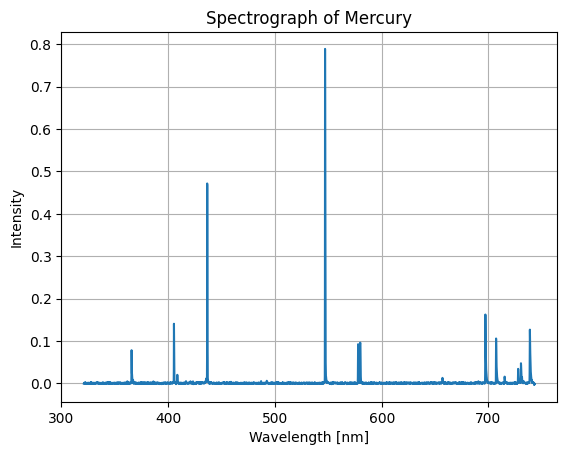

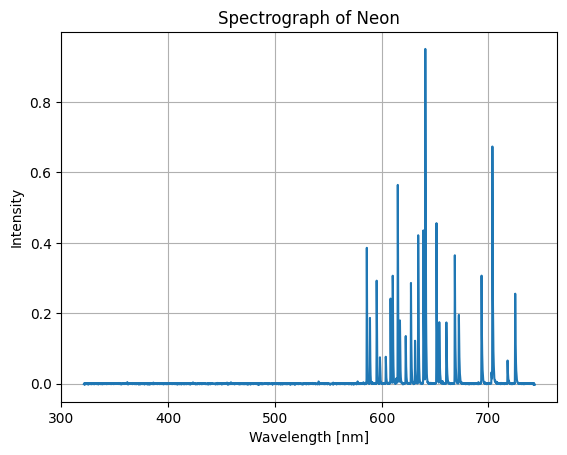

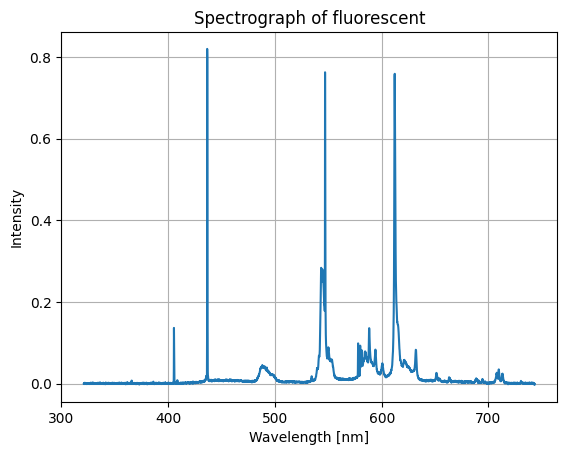

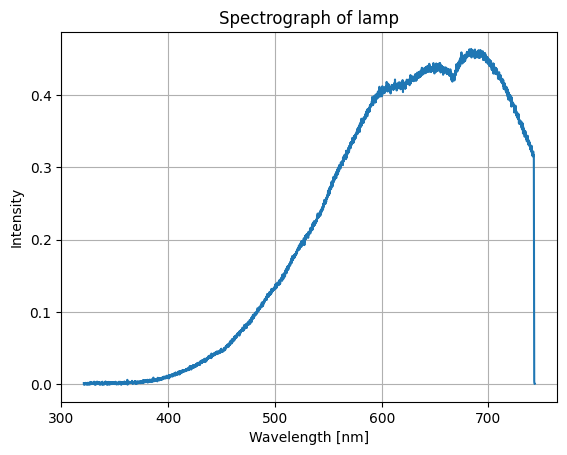

In [123]:
for i, data in enumerate(all_data):
    name = files[i][10:-4]
    x = data[:,0]
    y = data[:,1]
    plt.plot(x,y)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Intensity')
    plt.title(f'Spectrograph of {name}')
    plt.grid()
    plt.show()

## Centroid Function and Calculation

In [122]:
# Evan Watson's Function
def get_centroids(wavelengths, intensities, threshold=None, threshold_lim=0.01, scope=20):
    """
    gets centroid wavelengths for all peaks in intensity above certain threshold
    for a peak to count it has to be largest in scope radius
    meaning largest out of [scope] number of points forward and back

    Usage:
        get_centroids(wavelengths, intensities, threshold=0.01, scope=20)
        get_centroids(wavelengths, intensities, threshold_lim=0.005, scope=5)

    :param wavelengths: array of wavelengths, should not be list
    :param intensities: array of intensities, should not be list
    :param threshold: float, threshold value, adjust in tandem with scope
        if None, automatically determine threshold to be 1.1x mean value of intensities
    :param threshold_lim: float, minimum threshold if automatically determining threshold, default 0.01
    :param scope: int, scope radius, default 20,
        larger scope ensures no false peaks within small bump regions
        smaller scope allows for more peaks to be found (potentially false peaks too)
    :return: list of centroid wavelengths
    """
    if threshold is None:
        threshold = 1.1*ut.my_avg(intensities)
        if threshold < threshold_lim:
            threshold = threshold_lim

    n = len(intensities)
    peak_indices = []
    for i, I in enumerate(intensities):
        # don't count end points ("i-n" is negative version of index)
        if i<scope or (i-n)>=-scope:
            continue

        if I > threshold:
            # build like [i+scope, i+(scope-1), ..., i-(scope-1), i-scope]
            vals = [intensities[i-j] for j in range(-scope, scope+1) if j!=0]

            # make sure intensity is peak of scope
            if I > max(vals):
                peak_indices.append(i-1) # correct for column name

    centroids = []
    for k, peak_idx in enumerate(peak_indices):
        # go left until intensity drops below threshold
        left = peak_idx
        while left > 0 and intensities[left - 1] > threshold:
            left -= 1

        # repeat right
        right = peak_idx
        while right < n-1 and intensities[right + 1] > threshold:
            right += 1

        regional_wavelengths = wavelengths[left:right+1]
        regional_intensities = intensities[left:right+1]
        centroid = ut.my_sum(regional_wavelengths * regional_intensities) / ut.my_sum(regional_intensities)
        if centroid not in centroids:
            centroids.append(centroid-1) # correct for column name


    return centroids, peak_indices

for i, file in enumerate(files):
    name = files[i][10:-4]
    centroids, pix_num = get_centroids(all_data[i][:,0], all_data[i][:,1])
    print(f'Centroids of {name}')
    print(centroids)
    print(pix_num)
    print('########################')

Centroids of Hydrogen
[np.float32(433.74448), np.float32(485.98587), np.float32(656.26416)]
[1024, 1478, 2922]
########################
Centroids of Helium
[np.float32(388.6101), np.float32(446.93246), np.float32(471.0524), np.float32(491.91617), np.float32(501.38272), np.float32(587.54016), np.float32(667.7601), np.float32(706.3134), np.float32(727.8199)]
[623, 1139, 1350, 1530, 1611, 2345, 3019, 3342, 3523]
########################
Centroids of Mercury
[np.float32(364.79016), np.float32(404.42877), np.float32(407.53253), np.float32(435.5888), np.float32(546.0516), np.float32(578.9674), np.float32(655.8768), np.float32(696.4057), np.float32(706.4684), np.float32(714.1882), np.float32(726.94525), np.float32(729.7832), np.float32(738.12415)]
[408, 764, 792, 1039, 1993, 2273, 2922, 3259, 3343, 3410, 3516, 3538, 3608]
########################
Centroids of Neon
[np.float32(585.1902), np.float32(588.1336), np.float32(594.4629), np.float32(597.4999), np.float32(602.98987), np.float32(609.542

## Dispersions